# Autoencoder: CIFAR-10  - _Model Subclassing_ & TensorFlow 2

In [1]:
import tensorflow as tf
import tensorflow
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU, LeakyReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal
import numpy as np


In [2]:
print(f"TF version: {tf.__version__}")

TF version: 2.7.0


In [3]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"GPU: {gpu_devices}")

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: Tesla K80


#### Data preprocessing and cleaning:

In [5]:
# input image dimensions
img_rows, img_cols = 32, 32

In [6]:
# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [7]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [8]:
print(f"\ninput_shape to be used: {input_shape}")


input_shape to be used: (32, 32, 3)


In [9]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 200

In [10]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

By default the image data consists of integers between 0 and 255 for each pixel channel. Neural networks work best when each input is inside the range –1 to 1, so we need to divide by 255.

In [11]:
# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [12]:
print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape} & X_test.shape: {X_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (50000, 32, 32, 3) & X_test.shape: (10000, 32, 32, 3)


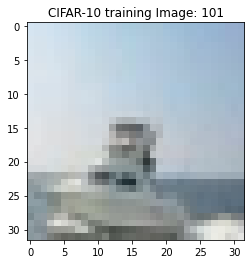

In [13]:
# Visualize CIFAR-10 dataset-
img_idx = 100

plt.imshow(X_train[img_idx])
plt.title(f"CIFAR-10 training Image: {img_idx + 1}")
plt.show()

### Define Autoencoder using _Model Subclassing_ & _Convolutional_ layers

In [14]:
class ConvBlock(Model):
    def __init__(
        self, num_filters,
        kernel_size, stride_length,
        pooling_size, pooling_stride,
        padding_type = 'same'
        ):
        super(ConvBlock, self).__init__()
        
        self.conv1 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            )
        
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.pool = MaxPooling2D(
            pool_size = pooling_size,
            strides = pooling_stride
            )
        
    def call(self, X):
        X = self.conv1(X)
        X = self.bn(X)
        X = tf.keras.activations.relu(X)
        X = self.pool(X)
        return X


In [15]:
class Conv6_Encoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Encoder, self).__init__()

        self.latent_dim = latent_dim
        
        self.conv_block1 = ConvBlock(
            num_filters = 64, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'same'
            )

        self.conv_block2 = ConvBlock(
            num_filters = 128, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'same'
            )
        
        self.conv_block3 = ConvBlock(
            num_filters = 256, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'same'
            )

        self.flatten = Flatten()
        
        self.output_layer = Dense(units = self.latent_dim
            )
    
    def call(self, X):
        X = self.conv_block1(X)
        X = self.conv_block2(X)
        X = self.conv_block3(X)
        X = self.flatten(X)
        X = tf.keras.activations.relu(self.output_layer(X))
        return X


In [16]:
class Conv6_Decoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Decoder, self).__init__()

        self.latent_dim = latent_dim
        
        self.inp_layer = InputLayer(input_shape = self.latent_dim)
        
        self.dense_layer = Dense(
            units = 4 * 4 * 256)
        self.bn1 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.reshape = Reshape((4, 4, 256))
        
        self.conv_transpose_layer1 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 2, padding = 'same'
            )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        """
        self.conv_layer2 = Conv2D(
            filters = 256, kernel_size = (3, 3),
            strides = (1, 1), padding = 'same'
        )
        """
        self.conv_transpose_layer2 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 1, padding = 'same'
            )
        
        self.bn3 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.conv_transpose_layer3 =  Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 2, padding = 'same'
            )
        self.bn4 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        """
        self.conv_layer4 = Conv2D(
            filters = 128, kernel_size = (3, 3),
            strides = (1, 1), padding = 'same'
        )
        """
        self.conv_transpose_layer4 = Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 1, padding = 'same'
            )
        
        self.bn5 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer5 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 2, padding = 'same'
            )
        self.bn6 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        """
        self.conv_layer6 = Conv2D(
            filters = 64, kernel_size = (3, 3),
            strides = (1, 1), padding = 'same'
        )
        """
        self.conv_transpose_layer6 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same'
            )
        
        self.bn7 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.final_conv_layer = Conv2DTranspose(
            filters = 3, kernel_size = 3,
            strides = 1, padding = 'same'
            )
        
    
    def call(self, X):
        X = self.inp_layer(X)
        X = tf.keras.activations.relu(self.bn1(self.dense_layer(X)))
        X = self.reshape(X)
        X = tf.keras.activations.relu(self.bn2(self.conv_transpose_layer1(X)))
        # X = tf.keras.activations.relu(self.bn3(self.conv_layer2(X)))
        X = tf.keras.activations.relu(self.bn3(self.conv_transpose_layer2(X)))
        X = tf.keras.activations.relu(self.bn4(self.conv_transpose_layer3(X)))
        # X = tf.keras.activations.relu(self.bn5(self.conv_layer4(X)))
        X = tf.keras.activations.relu(self.bn5(self.conv_transpose_layer4(X)))
        X = tf.keras.activations.relu(self.bn6(self.conv_transpose_layer5(X)))
        X = tf.keras.activations.relu(self.bn7(self.conv_transpose_layer6(X)))
        # X = tf.keras.activations.relu(self.bn7(self.conv_layer6(X)))
        X = tf.keras.activations.sigmoid(self.final_conv_layer(X))
        return X


In [17]:
# Sanity check-
encoder = Conv6_Encoder(latent_dim = 10)

In [18]:
X = encoder(X_train[:2, :])
X.shape

TensorShape([2, 10])

In [19]:
decoder = Conv6_Decoder(latent_dim = 10)

In [20]:
X_reconstructed = decoder(X)

In [21]:
X_reconstructed.shape

TensorShape([2, 32, 32, 3])

In [22]:
del X, X_reconstructed

In [23]:
# Specify latent-space dimensionality-
latent_space_dim = 100

# NOTE: Experiment with the latent space dimensionality for trade-off
# between reconstruction error and data compression.

In [24]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = Conv6_Encoder(latent_dim = self.latent_dim)
        self.decoder = Conv6_Decoder(latent_dim = self.latent_dim)
        
    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    

In [25]:
# Initialize an autoencoder instance-
model = Autoencoder(latent_dim = latent_space_dim)
# model.build(input_shape = (None, 32, 32, 3))

In [26]:
# Sanity check-
model(X_train[:5, :]).shape

TensorShape([5, 32, 32, 3])

In [27]:
# Count number of trainable parameters-
tot_params = 0
for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_params
    print(f"layer.shape = {layer.shape} has {loc_params} non-zero trainable params")

layer.shape = (3, 3, 3, 64) has 1728 non-zero trainable params
layer.shape = (64,) has 0 non-zero trainable params
layer.shape = (64,) has 64 non-zero trainable params
layer.shape = (64,) has 0 non-zero trainable params
layer.shape = (3, 3, 64, 128) has 73728 non-zero trainable params
layer.shape = (128,) has 0 non-zero trainable params
layer.shape = (128,) has 128 non-zero trainable params
layer.shape = (128,) has 0 non-zero trainable params
layer.shape = (3, 3, 128, 256) has 294912 non-zero trainable params
layer.shape = (256,) has 0 non-zero trainable params
layer.shape = (256,) has 256 non-zero trainable params
layer.shape = (256,) has 0 non-zero trainable params
layer.shape = (4096, 100) has 409600 non-zero trainable params
layer.shape = (100,) has 0 non-zero trainable params
layer.shape = (100, 4096) has 409600 non-zero trainable params
layer.shape = (4096,) has 0 non-zero trainable params
layer.shape = (4096,) has 4096 non-zero trainable params
layer.shape = (4096,) has 0 non-ze

In [28]:
print(f"Total number of trainable parameters in Autoencoder model = {tot_params}")

Total number of trainable parameters in Autoencoder model = 2929344


In [29]:
# Print model summary-
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv6__encoder_1 (Conv6_Enc  multiple                 782308    
 oder)                                                           
                                                                 
 conv6__decoder_1 (Conv6_Dec  multiple                 2168899   
 oder)                                                           
                                                                 
Total params: 2,951,207
Trainable params: 2,940,327
Non-trainable params: 10,880
_________________________________________________________________


In [30]:
# Save randomly initialized weights-
model.save_weights(
    "Autoencoder_CIFAR10_Model_Subclassing_Initial_Weights.h5",
    overwrite = True
    )

In [ ]:
'''
# Load randomly initialized weights-
model.load_weights(
    "Autoencoder_CIFAR10_Model_Subclassing_Initial_Weights.h5"
    )
'''

In [31]:
# Sanity check-
encoder_output = model.encoder(X_train[:2, :])
print(f"For input shape = {model(X_train[:2, :]).shape}, "
      f"encoder output shape = {encoder_output.shape}"
     )

For input shape = (2, 32, 32, 3), encoder output shape = (2, 100)


In [32]:
# Sanity check-
decoder_output = model.decoder(encoder_output)
print(f"For encoder output shape = {encoder_output.shape}, "
      f"decoder output shape = {decoder_output.shape}"
     )

For encoder output shape = (2, 100), decoder output shape = (2, 32, 32, 3)


In [33]:
del encoder_output, decoder_output

#### Loss function

The loss function is usually chosen to be either-
1. root mean squared error (RMSE) or
1. binary cross-entropy

between the individual pixels of the original image and the reconstruction.

__Binary cross-entropy places heavier penalties on predictions at the extremes that are badly wrong, so it tends to push pixel predictions to the middle of the range. This results in less vibrant images__.

For this reason, author generally prefer to use RMSE as the loss function. However, there is no right or wrong choice — you should choose whichever works best for your use case.

In [34]:
def RMSE_loss(y_true, y_pred):
    # RMSE loss function.
    return K.mean(K.square(y_true - y_pred), axis = [1, 2, 3])


In [35]:
# Compile defined autoencoder model-
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003),
    loss = RMSE_loss
    # loss = tf.keras.losses.BinaryCrossentropy()
    )

In [36]:
# Define early stopping criterion-
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', min_delta = 0.0001,
    patience = 4,
    restore_best_weights = True
)
# Adjust 'min_delta' according to training loss for early stopping
# to effectively happen.

In [37]:
num_epochs = 200
print(f"number of training epochs = {num_epochs}")

number of training epochs = 200


In [38]:
# Train autoencoder-
training_hist = model.fit(
    x = X_train, y = X_train,
    batch_size = batch_size, shuffle = True,
    validation_data = (X_test, X_test),
    epochs = num_epochs, callbacks = [early_stopping]
    )

Epoch 1/200
782/782 [==============================] - 97s 113ms/step - loss: 0.0180 - val_loss: 0.0147
Epoch 2/200
782/782 [==============================] - 80s 102ms/step - loss: 0.0114 - val_loss: 0.0133
Epoch 3/200
782/782 [==============================] - 85s 109ms/step - loss: 0.0103 - val_loss: 0.0123
Epoch 4/200
782/782 [==============================] - 80s 102ms/step - loss: 0.0099 - val_loss: 0.0104
Epoch 5/200
782/782 [==============================] - 80s 103ms/step - loss: 0.0097 - val_loss: 0.0113
Epoch 6/200
782/782 [==============================] - 80s 102ms/step - loss: 0.0095 - val_loss: 0.0102
Epoch 7/200
782/782 [==============================] - 79s 101ms/step - loss: 0.0094 - val_loss: 0.0098
Epoch 8/200
782/782 [==============================] - 80s 102ms/step - loss: 0.0093 - val_loss: 0.0099
Epoch 9/200
782/782 [==============================] - 80s 103ms/step - loss: 0.0091 - val_loss: 0.0099
Epoch 10/200
782/782 [==============================] - 80s 102m

In [40]:
# Save trained weights-
model.save_weights(
    "Autoencoder_CIFAR10_Model_Subclassing_Trained_Weights.h5",
    overwrite = True
    )

In [ ]:
# To load saved weights-
# model.load_weights("Autoencoder_CIFAR10_Model_Subclassing_Trained_Weights.h5")

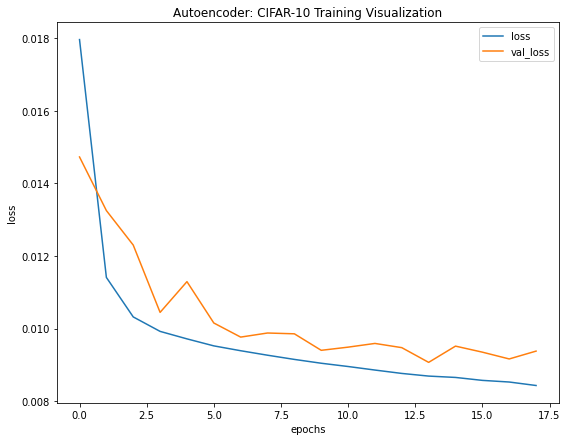

In [41]:
# Visualize training wrt loss-
plt.figure(figsize = (9, 7))
plt.plot(training_hist.history['loss'], label = 'loss')
plt.plot(training_hist.history['val_loss'], label = 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("Autoencoder: CIFAR-10 Training Visualization")
plt.show()

### Analysis of _trained_ Autoencoder:

In [42]:
encoded_X_train = model.encoder(X_train[:10000, :]).numpy()

In [43]:
encoded_X_test = model.encoder(X_test).numpy()

In [44]:
print(f"encoded_X_train.shape = {encoded_X_train.shape} & encoded_X_test = "
f"{encoded_X_test.shape}")

encoded_X_train.shape = (10000, 100) & encoded_X_test = (10000, 100)


In [45]:
# del encoded_X_train, encoded_X_test

In [ ]:
!pip install umap
!pip install umap-learn

In [44]:
# import umap
import umap.umap_ as umap

In [45]:
umap_model = umap.UMAP(n_components = 3)

In [46]:
# Get encoded latent space representation for train images-
encoded_X_train = umap_model.fit_transform(encoded_X_train)
print(f"encoded_X_train.shape: {encoded_X_train.shape}")

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


encoded_X_train.shape: (10000, 3)


In [47]:
# Get encoded latent space representations for test images-
encoded_X_test = umap_model.fit_transform(encoded_X_test)
print(f"encoded_X_test.shape: {encoded_X_test.shape}")

encoded_X_test.shape: (10000, 3)


In [48]:
import plotly.express as px

In [62]:
fig = px.scatter_3d(
    x = encoded_X_train[:, 0], y = encoded_X_train[:, 1],
    z = encoded_X_train[:, 2],
    color = y_train[:10000, :]
    )
fig.show()

In [63]:
fig = px.scatter_3d(
    x = encoded_X_test[:, 0], y = encoded_X_test[:, 1],
    z = encoded_X_test[:, 2],
    color = y_test
    )
fig.show()

### Visualize Actual vs. Recreated CIFAR-10 Images
Using __trained encoder__

In [46]:
recreated_image = model(X_train[:1, :])
recreated_image = recreated_image.numpy().reshape(32, 32, 3)

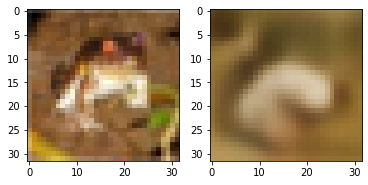

In [47]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_train[:1, :].reshape(32, 32, 3))
axarr[1].imshow(recreated_image)
plt.show()

In [48]:
recreated_image = model(X_train[100:101, :])
recreated_image = recreated_image.numpy().reshape(32, 32, 3)

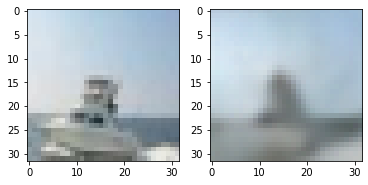

In [49]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_train[100:101, :].reshape(32, 32, 3))
axarr[1].imshow(recreated_image)
plt.show()

In [50]:
recreated_image = model(X_train[48012:48013, :])
recreated_image = recreated_image.numpy().reshape(32, 32, 3)

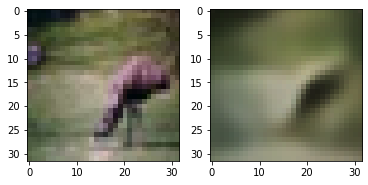

In [51]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_train[48012:48013, :].reshape(32, 32, 3))
axarr[1].imshow(recreated_image)
plt.show()

In [52]:
recreated_image = model(X_train[45999:46000, :])
recreated_image = recreated_image.numpy().reshape(32, 32, 3)

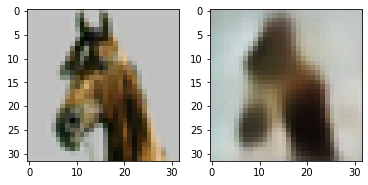

In [53]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_train[45999:46000, :].reshape(32, 32, 3))
axarr[1].imshow(recreated_image)
plt.show()

In [54]:
recreated_image = model(X_train[39999:40000, :])
recreated_image = recreated_image.numpy().reshape(32, 32, 3)

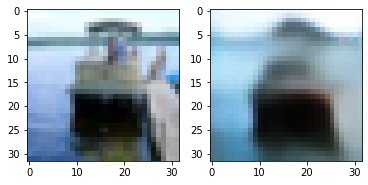

In [55]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_train[39999:40000, :].reshape(32, 32, 3))
axarr[1].imshow(recreated_image, cmap = 'gray')
plt.show()

### Observation:

The autoencoder is _not_ doing a good job of recreating CIFAR-10 images. The following two options can be explored to improve upon this-

1. Use a _Variational AutoEncoder_
1. Use a deeper CNN architecture for _encoder_ and _decoder_

### Compute class-wise reconstruction loss using trained encoder:

[Extract specific CIFAR-10 class(es)](https://stackoverflow.com/questions/59646288/is-there-a-way-to-extract-just-a-needed-class-from-cifar-10-training-dataset)

In [56]:
idx = (y_train == 0).reshape(X_train.shape[0])
print(f"Indices shape: {idx.shape}")

Indices shape: (50000,)


In [57]:
X_train_class0 = X_train[idx]
print(f"X_train_class0 shape: {X_train_class0.shape}")

X_train_class0 shape: (5000, 32, 32, 3)


In [61]:
# encoded_X_train_class0 = model.encoder(X_train_class0).numpy()

In [63]:
X_train_class0_recon = model(X_train_class0)

In [64]:
X_train_class0.shape, X_train_class0_recon.shape

((5000, 32, 32, 3), TensorShape([5000, 32, 32, 3]))

In [66]:
np.sum(RMSE_loss(X_train_class0, X_train_class0_recon).numpy())

36.090157

In [68]:
for i in range(10):
    idx = (y_train == i).reshape(X_train.shape[0])
    X_train_classi = X_train[idx]
    # print(f"X_train_class0 shape: {X_train_class0.shape}")
    X_train_classi_recon = model(X_train_classi)
    print(f"\nCIFAR-10 class = {i} has RMSE = "
    f"{np.sum(RMSE_loss(X_train_classi, X_train_classi_recon).numpy()):.4f}")


CIFAR-10 class = 0 has RMSE = 36.0902

CIFAR-10 class = 1 has RMSE = 56.0988

CIFAR-10 class = 2 has RMSE = 34.0354

CIFAR-10 class = 3 has RMSE = 40.7362

CIFAR-10 class = 4 has RMSE = 33.5810

CIFAR-10 class = 5 has RMSE = 42.8376

CIFAR-10 class = 6 has RMSE = 42.4401

CIFAR-10 class = 7 has RMSE = 47.4824

CIFAR-10 class = 8 has RMSE = 35.3230

CIFAR-10 class = 9 has RMSE = 56.1642


#### Observation:

Class 4 seems to have the smallest reconstruction error. While, class 9 has the highest reconstruction error.